# Stepwise Hyperparameter Tuning of XGBoost Classifier using Optuna

**Highlights:**
> 1. Demonstrate hyperparameter tuning using Optuna with an example.
>
> 2. Stepwise hyperparameter tuning of XGBoost classifier.
>
> 3. Demonstrate save and resume feature of Optuna
>
> 4. Hyperparameter tuning based on F1-score

* [1.   Import and Clean Data](#import-and-clean-data)
    * [1.1.   Missing values](#missing-values)
    * [1.2.   Deleting features](#deleting-features)
    * [1.3.  Modifying `Cabin` feature](#modifying-%60cabin%60-feature)
    * [1.4.   Find categorical columns and change their *Dtype* from `object` to `Categorical`](#find-categorical-columns-and-change-their-%2Adtype%2A-from-%60object%60-to-%60categorical%60)
* [2.   Data Preprocessing](#data-preprocessing)
    * [2.1.   Train-Test split](#train-test-split)
    * [2.2.   One-hot Encoding and Standardization](#one-hot-encoding-and-standardization)
* [3.   Utility Functions](#utility-functions)
* [4. Evaluation metric](#evaluation-metric)
* [5. XGBoost with default parameters](#xgboost-with-default-parameters)
* [6. What is Optuna?](#what-is-optuna%3F)
* [7. Stepwise Hyperparameter Tuning](#stepwise-hyperparameter-tuning)
    * [7.1. Resuming the optimization process in Optuna](#resuming-the-optimization-process-in-optuna)
* [8. Model Comparison](#model-comparison)

In [1]:
import os, sys

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id="import-and-clean-data"></a>
# 1.   Import and Clean Data

In [2]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')

In [3]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


<a id="missing-values"></a>
## 1.1.   Missing values

In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.dropna(subset=['Embarked'], inplace=True)

In [6]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

<a id="deleting-features"></a>
## 1.2.   Deleting features

Since `PassengerId`, `Name`, and `Ticket` columns do not provide any relevant information in predicting the survival of a passenger, we can delete the columns.

In [7]:
df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Cabin     202 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


<a id="modifying-%60cabin%60-feature"></a>
## 1.3.  Modifying `Cabin` feature
Since there are several null values in the `cabin` feature, we will modify the features values as missing (1) and not missing (0).

In [9]:
df['Cabin'] = df['Cabin'].isnull().astype(int)
df['Cabin'].value_counts()

1    687
0    202
Name: Cabin, dtype: int64

In [10]:
df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,1,S
1,1,1,female,38.0,1,0,71.2833,0,C


<a id="find-categorical-columns-and-change-their-%2Adtype%2A-from-%60object%60-to-%60categorical%60"></a>
## 1.4.   Find categorical columns and change their *Dtype* from `object` to `Categorical`

Finding categorical features and converting their pandas *dtype* to `categorical` will ease visualization

In [11]:
def summarize_categoricals(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Levels', 'No. of Levels', 'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]


def to_categorical(columns, df):
    """
        Converts the columns passed in `columns` to categorical datatype
    """
    for col in columns:
        df[col] = df[col].astype('category')
    return df

In [12]:
summarize_categoricals(df, show_levels=True)

,Levels,No. of Levels,No. of Missing Values
Survived,"[0, 1]",2,0
Pclass,"[3, 1, 2]",3,0
Sex,"[male, female]",2,0
Age,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,...",89,177
SibSp,"[1, 0, 3, 4, 2, 5, 8]",7,0
Parch,"[0, 1, 2, 5, 3, 4, 6]",7,0
Fare,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....",247,0
Cabin,"[1, 0]",2,0
Embarked,"[S, C, Q]",3,0


In [13]:
df = to_categorical(['Survived', 'Pclass', 'Sex',
                     'SibSp', 'Parch', 'Cabin', 'Embarked'], df)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  889 non-null    category
 1   Pclass    889 non-null    category
 2   Sex       889 non-null    category
 3   Age       712 non-null    float64 
 4   SibSp     889 non-null    category
 5   Parch     889 non-null    category
 6   Fare      889 non-null    float64 
 7   Cabin     889 non-null    category
 8   Embarked  889 non-null    category
dtypes: category(7), float64(2)
memory usage: 28.1 KB


<a id="data-preprocessing"></a>
# 2.   Data Preprocessing

In [15]:
x = df.iloc[:, 1:]
y = df['Survived']

categorical_columns = list(x.select_dtypes(include='category').columns)
numeric_columns = list(x.select_dtypes(exclude='category').columns)

In [16]:
categorical_columns, numeric_columns

(['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked'], ['Age', 'Fare'])

<a id="train-test-split"></a>
## 2.1.   Train-Test split

In [17]:
from sklearn.model_selection import train_test_split

data_splits = train_test_split(x, y, test_size=0.25, random_state=0,
                               shuffle=True, stratify=y)
x_train, x_test, y_train, y_test = data_splits

list(map(lambda x: x.shape, [x, y, x_train, x_test, y_train, y_test]))

[(889, 8), (889,), (666, 8), (223, 8), (666,), (223,)]

In [18]:
pd.Series(y_test).value_counts()

0    138
1     85
Name: Survived, dtype: int64

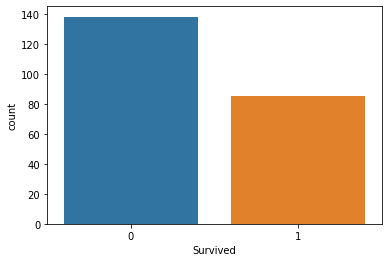

In [19]:
sns.countplot(x=y_test);

Since the dataset is imbalanced we will be using class-weighted/ cost-sensitive learning. In cost-sensitive learning, a weighted cost function is used. Therefore, misclassifying a sample from the minority class will cost the classifiers more than misclassifying a sample from the majority class. In most of the Sklearn classifiers, cost-sensitive learning can be enabled by setting `class_weight='balanced'`.

<a id="one-hot-encoding-and-standardization"></a>
## 2.2.   One-hot Encoding and Standardization
We need to standardize the continuous or quantitative variables/ features before applying Machine Learning models. This is important because if we don't standardize the features, features with high variance that are orders of magnitude larger that others might dominate the model fitting process and causing the model unable to learn from other features (with lower variance) correctly as expected. <br/>
There is no need to standardize categorical variables.

***Also we need to standardize the data only after performing train-test split because if we standardize before splitting then there is a chance for some information leak from the test set into the train set. We always want the test set to be completely new to the ML models. [Read more](https://scikit-learn.org/stable/modules/compose.html#columntransformer-for-heterogeneous-data)***

In [20]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin         0
Embarked      0
dtype: int64

We need to impute values in `Age`.

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', dtype=np.int))
])

## Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])


## Applying Column Transformer
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)


## Label encoding
y_trans = LabelEncoder()
y_train = y_trans.fit_transform(y_train)
y_test = y_trans.transform(y_test)


## Save feature names after one-hot encoding for feature importances plots
feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'] \
                            .get_feature_names(input_features=categorical_columns))
feature_names = feature_names + numeric_columns

<a id="utility-functions"></a>
# 3.   Utility Functions

In [22]:
import timeit
import pickle
import sys
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            precision_recall_curve, roc_curve, accuracy_score
from sklearn.exceptions import NotFittedError

In [23]:
def confusion_plot(matrix, labels=None):
    """ Display binary confusion matrix as a Seaborn heatmap """
    
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    sns.heatmap(data=matrix, cmap='Blues', annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    ax.set_title('Confusion Matrix')
    plt.close()
    
    return fig

In [24]:
def roc_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Receiver Operating Characteristic (ROC) curve 
        Set `compare=True` to use this function to compare classifiers. """
    
    fpr, tpr, thresh = roc_curve(y_true, y_probs,
                                 drop_intermediate=False)
    auc = round(roc_auc_score(y_true, y_probs), 2)
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    label = ' '.join([label, f'({auc})']) if compare else None
    sns.lineplot(x=fpr, y=tpr, ax=axis, label=label)
    
    if compare:
        axis.legend(title='Classifier (AUC)', loc='lower right')
    else:
        axis.text(0.72, 0.05, f'AUC = { auc }', fontsize=12,
                  bbox=dict(facecolor='green', alpha=0.4, pad=5))
            
        # Plot No-Info classifier
        axis.fill_between(fpr, fpr, tpr, alpha=0.3, edgecolor='g',
                          linestyle='--', linewidth=2)
        
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('ROC Curve')
    axis.set_xlabel('False Positive Rate [FPR]\n(1 - Specificity)')
    axis.set_ylabel('True Positive Rate [TPR]\n(Sensitivity or Recall)')
    
    plt.close()
    
    return axis if ax else fig

In [25]:
def precision_recall_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Precision-Recall curve.
        Set `compare=True` to use this function to compare classifiers. """
    
    p, r, thresh = precision_recall_curve(y_true, y_probs)
    p, r, thresh = list(p), list(r), list(thresh)
    p.pop()
    r.pop()
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    
    if compare:
        sns.lineplot(r, p, ax=axis, label=label)
        axis.set_xlabel('Recall')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')
    else:
        sns.lineplot(thresh, p, label='Precision', ax=axis)
        axis.set_xlabel('Threshold')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')

        axis_twin = axis.twinx()
        sns.lineplot(thresh, r, color='limegreen', label='Recall', ax=axis_twin)
        axis_twin.set_ylabel('Recall')
        axis_twin.set_ylim(0, 1)
        axis_twin.legend(bbox_to_anchor=(0.24, 0.18))
    
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('Precision Vs Recall')
    
    plt.close()
    
    return axis if ax else fig

In [26]:
def feature_importance_plot(importances, feature_labels, ax=None):
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    sns.barplot(x=importances, y=feature_labels, ax=axis)
    axis.set_title('Feature Importance Measures')
    
    plt.close()
    
    return axis if ax else fig

In [27]:
def train_clf(clf, x_train, y_train, sample_weight=None, refit=False):
    train_time = 0
    
    try:
        if refit:
            raise NotFittedError
        y_pred_train = clf.predict(x_train)
    except NotFittedError:
        start = timeit.default_timer()
        
        if sample_weight is not None:
            clf.fit(x_train, y_train, sample_weight=sample_weight)
        else:
            clf.fit(x_train, y_train)
        
        end = timeit.default_timer()
        train_time = end - start
        
        y_pred_train = clf.predict(x_train)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    return clf, y_pred_train, train_acc, train_time

In [28]:
def model_memory_size(clf):
    return sys.getsizeof(pickle.dumps(clf))

In [29]:
def report(clf, x_train, y_train, x_test, y_test, display_scores=[],
           sample_weight=None, refit=False, importance_plot=False,
           confusion_labels=None, feature_labels=None, verbose=True):
    """ Trains the passed classifier if not already trained and reports
        various metrics of the trained classifier """
    
    dump = dict()
    
    ## Train if not already trained
    clf, train_predictions, \
    train_acc, train_time = train_clf(clf, x_train, y_train,
                                      sample_weight=sample_weight,
                                      refit=refit)
    ## Testing
    start = timeit.default_timer()
    test_predictions = clf.predict(x_test)
    end = timeit.default_timer()
    test_time = end - start
    
    test_acc = accuracy_score(y_test, test_predictions)
    y_probs = clf.predict_proba(x_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_probs)
        
    ## Additional scores
    scores_dict = dict()
    for func in display_scores:
        scores_dict[func.__name__] = [func(y_train, train_predictions),
                                      func(y_test, test_predictions)]
        
    ## Model Memory
    model_mem = round(model_memory_size(clf) / 1024, 2)
    
    print(clf)
    print("\n=============================> TRAIN-TEST DETAILS <======================================")
    
    ## Metrics
    print(f"Train Size: {x_train.shape[0]} samples")
    print(f" Test Size: {x_test.shape[0]} samples")
    print("---------------------------------------------")
    print(f"Training Time: {round(train_time, 3)} seconds")
    print(f" Testing Time: {round(test_time, 3)} seconds")
    print("---------------------------------------------")
    print("Train Accuracy: ", train_acc)
    print(" Test Accuracy: ", test_acc)
    print("---------------------------------------------")
    
    if display_scores:
        for k, v in scores_dict.items():
            score_name = ' '.join(map(lambda x: x.title(), k.split('_')))
            print(f'Train {score_name}: ', v[0])
            print(f' Test {score_name}: ', v[1])
            print()
        print("---------------------------------------------")
    
    print(" Area Under ROC (test): ", roc_auc)
    print("---------------------------------------------")
    print(f"Model Memory Size: {model_mem} kB")
    print("\n=============================> CLASSIFICATION REPORT <===================================")
    
    ## Classification Report
    clf_rep = classification_report(y_test, test_predictions, output_dict=True)
    
    print(classification_report(y_test, test_predictions,
                                target_names=confusion_labels))
    
    
    if verbose:
        print("\n================================> CONFUSION MATRIX <=====================================")
    
        ## Confusion Matrix HeatMap
        display(confusion_plot(confusion_matrix(y_test, test_predictions),
                               labels=confusion_labels))
        print("\n=======================================> PLOTS <=========================================")


        ## Variable importance plot
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        roc_axes = axes[0, 0]
        pr_axes = axes[0, 1]
        importances = None

        if importance_plot:
            if not feature_labels:
                raise RuntimeError("'feature_labels' argument not passed "
                                   "when 'importance_plot' is True")

            try:
                importances = pd.Series(clf.feature_importances_,
                                        index=feature_labels) \
                                .sort_values(ascending=False)
            except AttributeError:
                try:
                    importances = pd.Series(clf.coef_.ravel(),
                                            index=feature_labels) \
                                    .sort_values(ascending=False)
                except AttributeError:
                    pass

            if importances is not None:
                # Modifying grid
                grid_spec = axes[0, 0].get_gridspec()
                for ax in axes[:, 0]:
                    ax.remove()   # remove first column axes
                large_axs = fig.add_subplot(grid_spec[0:, 0])

                # Plot importance curve
                feature_importance_plot(importances=importances.values,
                                        feature_labels=importances.index,
                                        ax=large_axs)
                large_axs.axvline(x=0)

                # Axis for ROC and PR curve
                roc_axes = axes[0, 1]
                pr_axes = axes[1, 1]
            else:
                # remove second row axes
                for ax in axes[1, :]:
                    ax.remove()
        else:
            # remove second row axes
            for ax in axes[1, :]:
                ax.remove()


        ## ROC and Precision-Recall curves
        clf_name = clf.__class__.__name__
        roc_plot(y_test, y_probs, clf_name, ax=roc_axes)
        precision_recall_plot(y_test, y_probs, clf_name, ax=pr_axes)

        fig.subplots_adjust(wspace=5)
        fig.tight_layout()
        display(fig)
    
    ## Dump to report_dict
    dump = dict(clf=clf, accuracy=[train_acc, test_acc], **scores_dict,
                train_time=train_time, train_predictions=train_predictions,
                test_time=test_time, test_predictions=test_predictions,
                test_probs=y_probs, report=clf_rep, roc_auc=roc_auc,
                model_memory=model_mem)
    
    return clf, dump

In [30]:
def compare_models(y_test=None, clf_reports=[], labels=[], score='accuracy'):
    """ Compare evaluation metrics for the True Positive class [1] of 
        binary classifiers passed in the argument and plot ROC and PR curves.
        
        Arguments:
        ---------
        y_test: to plot ROC and Precision-Recall curves
         score: is the name corresponding to the sklearn metrics
        
        Returns:
        -------
        compare_table: pandas DataFrame containing evaluated metrics
                  fig: `matplotlib` figure object with ROC and PR curves """

    
    ## Classifier Labels
    default_names = [rep['clf'].__class__.__name__ for rep in clf_reports]
    clf_names =  labels if len(labels) == len(clf_reports) else default_names
    
    
    ## Compare Table
    table = dict()
    index = ['Train ' + score, 'Test ' + score, 'Overfitting', 'ROC Area',
             'Precision', 'Recall', 'F1-score', 'Support']
    for i in range(len(clf_reports)):
        scores = [round(i, 3) for i in clf_reports[i][score]]
        
        roc_auc = clf_reports[i]['roc_auc']
        
        # Get metrics of True Positive class from sklearn classification_report
        true_positive_metrics = list(clf_reports[i]['report']["1"].values())
        
        table[clf_names[i]] = scores + [scores[1] < scores[0], roc_auc] + \
                              true_positive_metrics
    
    table = pd.DataFrame(data=table, index=index)
    
    
    ## Compare Plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # ROC and Precision-Recall
    for i in range(len(clf_reports)):
        clf_probs = clf_reports[i]['test_probs']
        roc_plot(y_test, clf_probs, label=clf_names[i],
                 compare=True, ax=axes[0])
        precision_recall_plot(y_test, clf_probs, label=clf_names[i],
                              compare=True, ax=axes[1])
    # Plot No-Info classifier
    axes[0].plot([0,1], [0,1], linestyle='--', color='green')
        
    fig.tight_layout()
    plt.close()
    
    return table.T, fig

<a id="evaluation-metric"></a>
# 4. Evaluation metric
Since the titanic dataset is imbalanced, F1-score is a more appropriate metric than accuracy. Therefore, we will use F1-score as the evaluation metric while performing hyperparameter tuning of XGBoost classifier using Optuna.

<a id="xgboost-with-default-parameters"></a>
# 5. XGBoost with default parameters

In [31]:
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn import metrics

In [32]:
primary_eval_metric = metrics.f1_score
confusion_lbs = ['Not Survived', 'Survived']

## Compute `class_weights` using sklearn
cls_weight = (y_train.shape[0] - np.sum(y_train)) / np.sum(y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.611764705882353,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 666 samples
 Test Size: 223 samples
---------------------------------------------
Training Time: 0 seconds
 Testing Time: 0.004 seconds
---------------------------------------------
Train Accuracy:  0.9864864864864865
 Test Accuracy:  0.8430493273542601
------------------------------

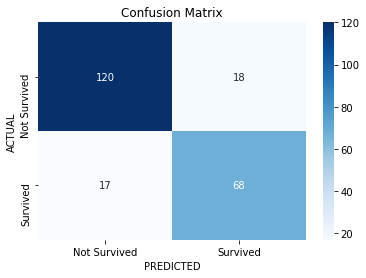


=======================================> PLOTS <=========================================


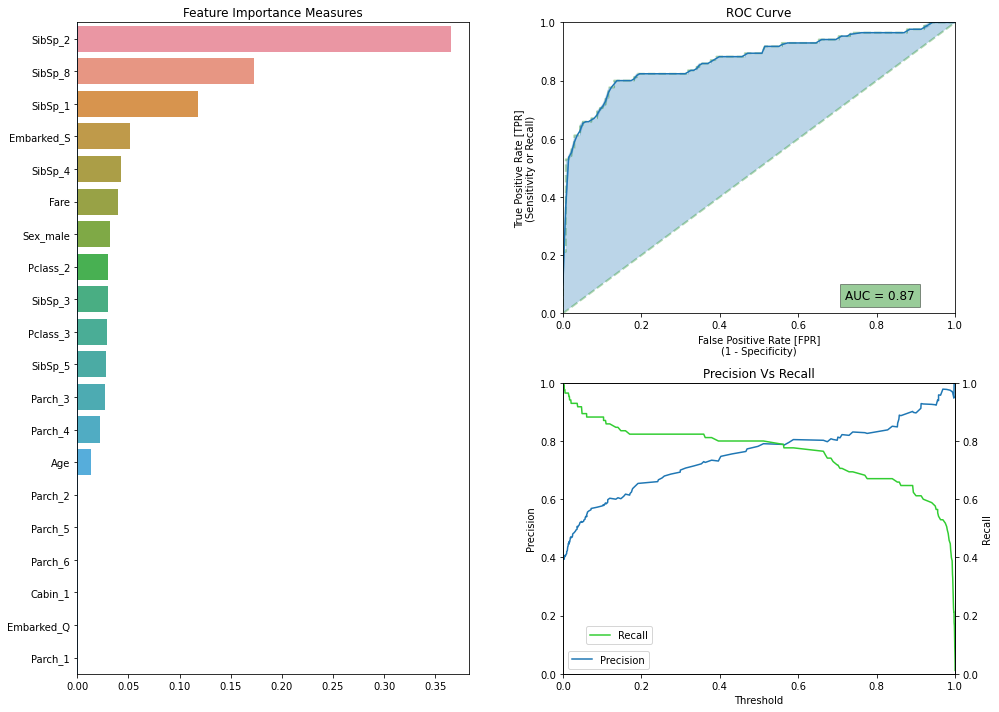

In [33]:
xgb_clf_default = XGBClassifier(scale_pos_weight=cls_weight,
                                random_state=0, n_jobs=-1)
xgb_clf_default.fit(x_train, y_train);

xgb_clf_default, xgb_report_default = report(xgb_clf_default, x_train, y_train,
                                             x_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

As we can see, the XGBoost classifier in its default configuration is overfitting in terms of F1-score.

<a id="what-is-optuna%3F"></a>
# 6. What is Optuna?
Optuna is one of the optimization libraries that use Sequential Model Based Optimization (SMBO). Conventional optimization approaches like Grid search and Random search do not make use of the information available regarding the previously explored hyperparameter search space. Unlike those techniques, SMBO techniques use the historical exploration information to make a more informed decision regarding the direction in which the optimizer should explore next in the search space. Such a mechanism gives SMBO techniques an edge over the conventional approaches in terms of convergence speed. 

**Advantages of SMBO:** 
> 1. Requires fewer iterations/ trials to converge, even if the search space is very huge.
>
> 2. Search is more focused in the region of the search space that is closer to the true optimal point.
>
> 3. Facilitates pausing and continuing the optimization process. 

Some examples of SMBO based optimization libraries:- Skopt, Hyperopt, Optuna 

**Advantages of Optuna over Hyperopt and Skopt:**
> 1. Provides support storing the optimization information in a database. Hence, facilitates saving and resuming the optimization process, unlike Hyperopt and Skopt.
>
> 2. The interface and documentation is more mature than Skopt and Hyperopt.

<a id="stepwise-hyperparameter-tuning"></a>
# 7. Stepwise Hyperparameter Tuning
The stepwise algorithm for XGBoost hyperparameter tuning is inspired by a similar algorithm for LightGBM explained in [this post](https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258). 

The most commonly used and the most effective XGBoost parameters are split into 3 groups: 

> **GROUP 1:** max_depth , min_child_weight 
>
> **GROUP 2:** subsample, colsample_bytree 
>
> **GROUP 3:** learning_rate, num_boost_round 

Initially, `learning_rate` and `num_boost_round` are fixed at 0.1 and 1000 respectively.

Each of these groups of hyperparameters are tuned sequentially. While tuning a particular group, all the subsequent groups are fixed at default or initial values and all the preceding groups are fixed at the values obtained after the tuning process. For example, by the time execution reachs GROUP 2, GROUP 1 is already tuned so we will fix GROUP 1 at the optimal values obtained, while the parameters in the subsequent groups (only GROUP 3 in this case) are left default or at the intialized values (0.1 and 1000 in this case) since they still need to be tuned. 

The benefit of stepwise tuning is that the hyperparameter space is narrowed down to the group being tuned. In conventional tuning methods, we tune all the hyperparameters togeather which requires searching through a larger space. For instance, in this case we have 6 hyperparameters, tuning all of them together will involve searching through a 6 dimensional space. However, if stepwise algorithm is used, we will have to search a space of only 2 dimensions at once which is way more efficient and faster than searching through a larger space. 

In [34]:
import xgboost as xgb
from optuna import create_study, logging
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback


def objective(trial, X, y, group, score, params=dict()):
    dtrain = xgb.DMatrix(X, label=y)
    class_weight = (y.shape[0] - np.sum(y)) / np.sum(y)
    
    ## Initial Learning Parameters
    params['learning_rate'] = 0.1
    params['num_boost_round'] = 1000

    if group == '1':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 10)
        params['min_child_weight'] = trial.suggest_loguniform('min_child_weight',
                                                              1e-10, 1e10)
    
    if group == '2':
        params['subsample'] = trial.suggest_uniform('subsample', 0, 1)
        params['colsample_bytree'] = trial.suggest_uniform('colsample_bytree', 0, 1)
    
    if group == '3':
        params['learning_rate'] = trial.suggest_uniform('learning_rate', 0, 0.1)
        params['num_boost_round'] = trial.suggest_int('num_boost_round', 100, 1000)

    pruning_callback = XGBoostPruningCallback(trial, "test-" + score.__name__)
    cv_scores = xgb.cv(params, dtrain, nfold=5,
                       stratified=True,
                       feval=score,
                       early_stopping_rounds=10,
                       callbacks=[pruning_callback],
                       seed=0)

    return cv_scores['test-' + score.__name__ + '-mean'].values[-1]


def execute_optimization(study_name, group, score, trials,
                         params=dict(), direction='maximize'):
    logging.set_verbosity(logging.ERROR)
    
    ## We use pruner to skip trials that are NOT fruitful
    pruner = MedianPruner(n_warmup_steps=5)
    
    study = create_study(direction=direction,
                         study_name=study_name,
                         storage='sqlite:///optuna.db',
                         load_if_exists=True,
                         pruner=pruner)

    study.optimize(lambda trial: objective(trial, x_train, y_train,
                                           group, score, params),
                   n_trials=trials,
                   n_jobs=-1)
    
    
    print("STUDY NAME: ", study_name)
    print('------------------------------------------------')
    print("EVALUATION METRIC: ", score.__name__)
    print('------------------------------------------------')
    print("BEST CV SCORE", study.best_value)
    print('------------------------------------------------')
    print(f"OPTIMAL GROUP - {group} PARAMS: ", study.best_params)
    print('------------------------------------------------')
    print("BEST TRIAL", study.best_trial)
    print('------------------------------------------------')
    
    
    return study.best_params

Since XGBoost does not have F1-score as one of the evaluation metrics, we will have a pass a custom F1-score function in the `feval=` parameter of the `xgb.cv` method.

In [35]:
score_func = metrics.f1_score
def score_function(y_pred, dtrain):
    y_pred = (y_pred > 0.5).astype(int)
    y_true = (dtrain.get_label() > 0.5).astype(int)
    return score_func.__name__, score_func(y_true, y_pred)

score_function.__name__ = score_func.__name__

In [36]:
def stepwise_optimization(trials=10):
    final_params = dict()
    for g in ['1', '2', '3']:
        print(f"=========================== Optimizing Group - {g} ============================")
        update_params = execute_optimization('xgboost', g, score_function, trials,
                                             params=final_params, direction='maximize')
        final_params.update(update_params)
        print(f"PARAMS after optimizing GROUP - {g}: ", final_params)
        print()
        print()

    print("=========================== FINAL OPTIMAL PARAMETERS ============================")
    print(final_params)
    
    return final_params

In [37]:
params = stepwise_optimization()

=========================== Optimizing Group - 1 ============================
STUDY NAME:  xgboost
------------------------------------------------
EVALUATION METRIC:  f1_score
------------------------------------------------
BEST CV SCORE 0.7042080000000001
------------------------------------------------
OPTIMAL GROUP - 1 PARAMS:  {'max_depth': 3, 'min_child_weight': 0.0008744811732146409}
------------------------------------------------
BEST TRIAL FrozenTrial(number=4, value=0.7042080000000001, datetime_start=datetime.datetime(2020, 8, 27, 6, 32, 38, 448133), datetime_complete=datetime.datetime(2020, 8, 27, 6, 32, 41, 339302), params={'max_depth': 3, 'min_child_weight': 0.0008744811732146409}, distributions={'max_depth': IntUniformDistribution(high=10, low=2, step=1), 'min_child_weight': LogUniformDistribution(high=10000000000.0, low=1e-10)}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.7156712, 1: 0.715403, 2: 0.7149015999999999, 3: 0.7205793999999999, 4: 0.7152486, 5:

In [38]:
params

{'learning_rate': 0.0667846149728314,
 'num_boost_round': 397,
 'max_depth': 3,
 'min_child_weight': 0.0008744811732146409,
 'subsample': 0.033981160117708575,
 'colsample_bytree': 0.3639480531900633}

Let's run the XGB classifier using the obtained optimal hyperparameters and check if it is outside the overfitting region.

[06:32:56] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3639480531900633, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0667846149728314, max_delta_step=0, max_depth=3,
              min_child_weight=0.0008744811732146409, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_boost_round=397, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.611764705882353,
              subsample=0.033981160117708575, tree_method='exact',

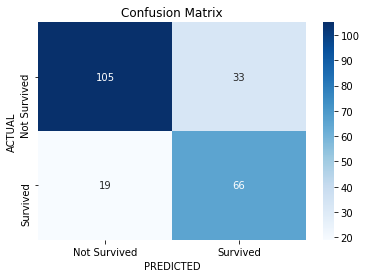


=======================================> PLOTS <=========================================


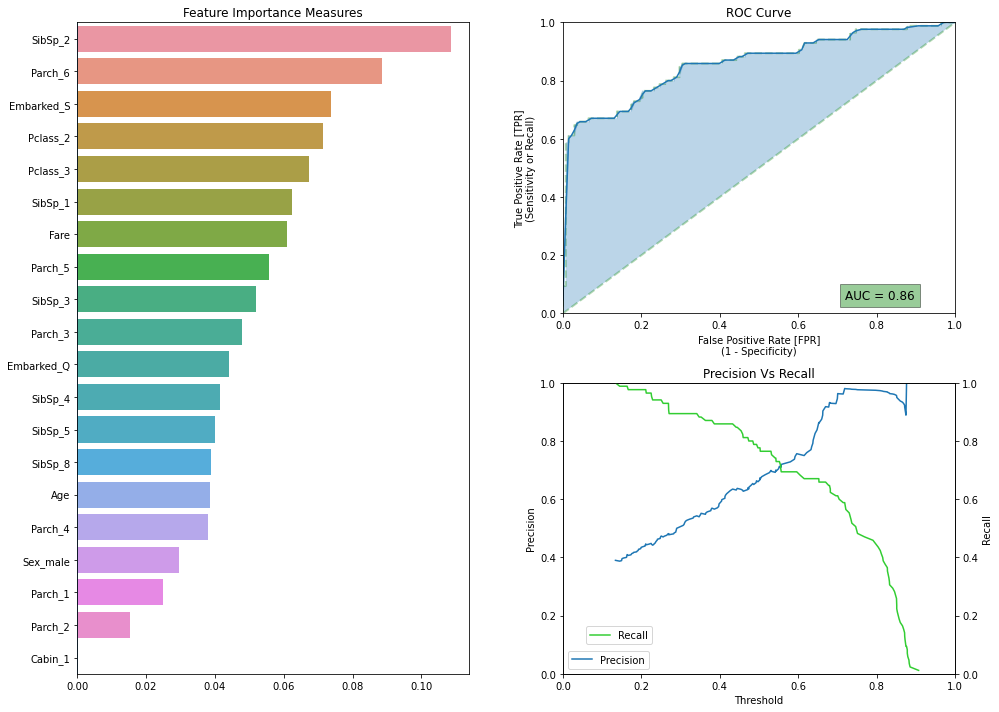

In [39]:
xgb_clf_tuned_1 = XGBClassifier(**params, scale_pos_weight=cls_weight,
                                random_state=0, n_jobs=-1)
xgb_clf_tuned_1.fit(x_train, y_train);

xgb_clf_tuned_1, xgb_report_tuned_1 = report(xgb_clf_tuned_1, x_train, y_train,
                                             x_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

<a id="resuming-the-optimization-process-in-optuna"></a>
## 7.1. Resuming the optimization process in Optuna
Since the classifier is still overfitting, we can ***continue/ resume*** the optimization process just by running the optimization process again on the same study by passing the study name and storage location to the **study_name** and **storage** arguments of the `create_study` method (see `execute_optimization` function).

Since I am calling the from the `execute_optimization` function from the `stepwise_optimization` function, we just have to execute the `stepwise_optimization` function once more but with more trails.

In [40]:
params = stepwise_optimization(trials=50)

=========================== Optimizing Group - 1 ============================
STUDY NAME:  xgboost
------------------------------------------------
EVALUATION METRIC:  f1_score
------------------------------------------------
BEST CV SCORE 0.7069058
------------------------------------------------
OPTIMAL GROUP - 1 PARAMS:  {'max_depth': 2, 'min_child_weight': 7.574953159100704}
------------------------------------------------
BEST TRIAL FrozenTrial(number=76, value=0.7069058, datetime_start=datetime.datetime(2020, 8, 27, 6, 33, 34, 82928), datetime_complete=datetime.datetime(2020, 8, 27, 6, 33, 37, 383438), params={'max_depth': 2, 'min_child_weight': 7.574953159100704}, distributions={'max_depth': IntUniformDistribution(high=10, low=2, step=1), 'min_child_weight': LogUniformDistribution(high=10000000000.0, low=1e-10)}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.7032552, 1: 0.7049822, 2: 0.6998122, 3: 0.7049822, 4: 0.7069058, 5: 0.7026192, 6: 0.7069058, 7: 0.7069058, 8: 

In [41]:
params

{'learning_rate': 0.018545066485002128,
 'num_boost_round': 644,
 'max_depth': 2,
 'min_child_weight': 7.574953159100704,
 'subsample': 0.9426340819991916,
 'colsample_bytree': 0.9105243559214375}

Let's run the XGB classifier using the obtained optimal hyperparameters.

[06:34:49] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9105243559214375, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.018545066485002128, max_delta_step=0, max_depth=2,
              min_child_weight=7.574953159100704, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_boost_round=644, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.611764705882353,
              subsample=0.9426340819991916, tree_method='exact',
   

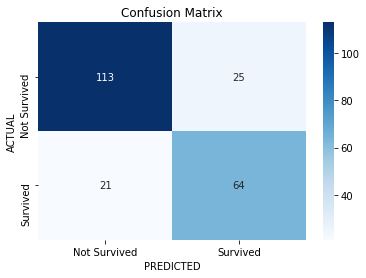


=======================================> PLOTS <=========================================


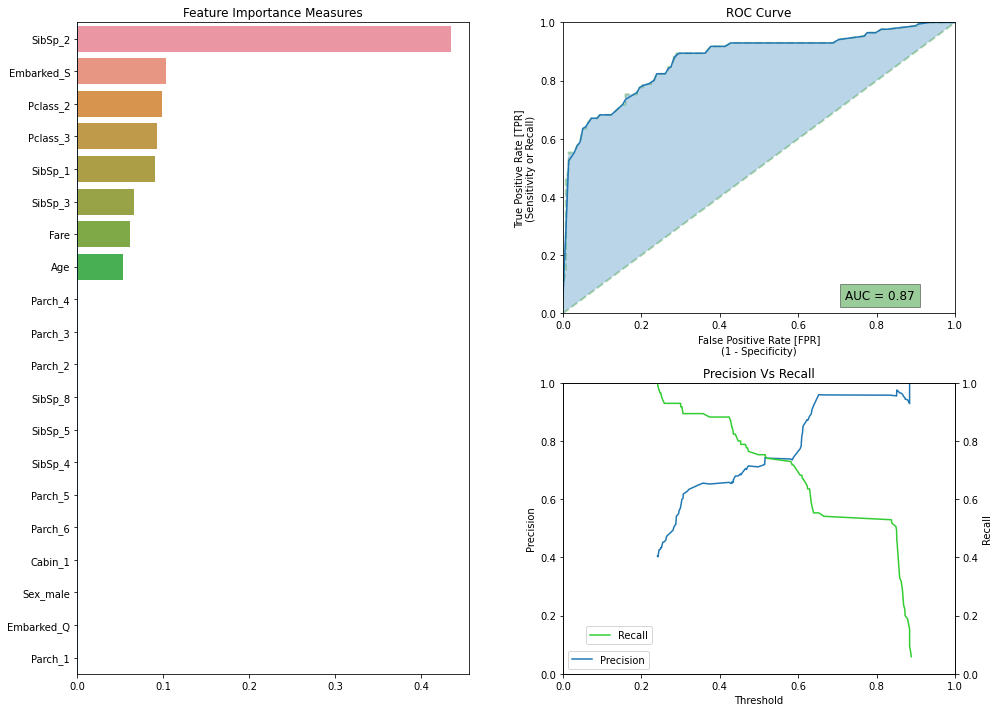

In [42]:
xgb_clf_tuned_2 = XGBClassifier(**params, scale_pos_weight=cls_weight,
                                random_state=0, n_jobs=-1)
xgb_clf_tuned_2.fit(x_train, y_train);

xgb_clf_tuned_2, xgb_report_tuned_2 = report(xgb_clf_tuned_2, x_train, y_train,
                                             x_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

<a id="model-comparison"></a>
# 8. Model Comparison

In [43]:
report_list = [xgb_report_default, xgb_report_tuned_1, xgb_report_tuned_2]
clf_labels = ['XGBoost with default params',
              'XGBoost after 10 trials',
              'XGBoost after 50 more trials',]

In [44]:
compare_table, compare_plot = compare_models(y_test, clf_reports=report_list,
                                             labels=clf_labels,
                                             score=primary_eval_metric.__name__)

compare_table

,Train f1_score,Test f1_score,Overfitting,ROC Area,Precision,Recall,F1-score,Support
XGBoost with default params,0.983,0.795,True,0.872634,0.790698,0.8,0.795322,85
XGBoost after 10 trials,0.728,0.717,True,0.859079,0.666667,0.776471,0.717391,85
XGBoost after 50 more trials,0.73,0.736,False,0.87468,0.719101,0.752941,0.735632,85


Thank You!!